In [220]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [221]:
data = pd.read_csv("Top_5_Leagues_23_24.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [222]:
def add_carries(game_df):
   min_dribble_length: float = 0.0
   max_dribble_length: float = 100.0
   max_dribble_duration: float = 20.0
   game_df['time_seconds']=game_df['minute']*60+game_df['second']
   next_actions = data.shift(-1)
   same_game=game_df.gameId==next_actions.gameId
   same_team = game_df.teamId == next_actions.teamId
   dx = game_df.endX - next_actions.x
   dy = game_df.endY- next_actions.y
   far_enough=dy** 2 + dy** 2 >= min_dribble_length** 2
   not_too_far = dx ** 2+ dy** 2<= max_dribble_length ** 2
   dt = next_actions.time_seconds - game_df.time_seconds
   same_phase = dt < max_dribble_duration
   same_period = game_df.period == next_actions.period
   dribble_idx = same_team & far_enough & not_too_far & same_phase & same_period&same_game
   dribbles = pd.DataFrame()
   prev = game_df[dribble_idx]
   nex= next_actions[dribble_idx]
   dribbles['gameId' ] = nex.gameId
   dribbles['period' ] = nex.period
   for cols in ['expandedMinute']:
      dribbles[cols] = nex[cols]
   for cols in ['passKey','assist']:
      dribbles[ cols] = [True for _ in range (len (dribbles))]
   dribbles['isTouch'] = [True for _ in range (len (dribbles))]
   morecols = ['playerId', 'team','player']
   for cols in morecols:
      dribbles[cols] = nex[cols]
   #dribbles['action_id'] = prev.eventId + 0.1
   dribbles['time_seconds' ] = (prev.time_seconds + nex.time_seconds) / 2
   dribbles['teamId'] = nex.teamId
   dribbles['playerId']= nex.playerId
   dribbles['player' ]= nex.player
   dribbles['x'] = prev.endX
   dribbles['y']= prev.endY
   dribbles['endX'] = nex.x
   dribbles['endY'] = nex.y
   dribbles['type'] = ['Carry' for _ in range(len(dribbles))]
   dribbles['outcomeType'] = ['Successful' for _ in range(len(dribbles))]
   dribbles['qualifiers']=[{} for _ in range(len(dribbles))]
   game_df=pd.concat([game_df,dribbles], ignore_index=True,sort=False)
   game_df=game_df.sort_values(['gameId','period']).reset_index(drop=True)
   game_df['action_id']=range(len(game_df))
   return game_df

In [223]:
data = add_carries(data)

In [224]:
data_passes = data[(data['type'] == 'Pass') & (data['x'] <= 119.2)]
data_succ = data_passes[data_passes['outcomeType'] == 'Successful']
data_unsucc = data_passes[data_passes['outcomeType'] == 'Unsuccessful']

In [225]:
data_carries = data[data['type'] == 'Carry']

In [239]:
def calculate_progressive_passes(df):
    df_prog = df.reset_index()
    df_prog['beginning'] = np.sqrt(np.square(120 - df_prog['x']) + np.square(40 - df_prog['y']))
    df_prog['end'] = np.sqrt(np.square(120 - df_prog['endX']) + np.square(40 - df_prog['endY']))
    df_prog['progressive'] = (df_prog['end'] / df_prog['beginning']) < 0.75
    return df_prog[df_prog['progressive']]

def calculate_progressive_carries(df):
    df_prog = df.reset_index()
    df_prog['beginning'] = np.sqrt(np.square(120 - df_prog['x']) + np.square(40 - df_prog['y']))
    df_prog['end'] = np.sqrt(np.square(120 - df_prog['endX']) + np.square(40 - df_prog['endY']))
    df_prog['progressive'] = (df_prog['end'] / df_prog['beginning']) < 0.75
    return df_prog[df_prog['progressive']]


prog_passes = calculate_progressive_passes(data_succ)
prog_carries = calculate_progressive_carries(data_carries)

prog_passes_grouped = prog_passes.groupby(['playerId', 'player', 'team']).size().reset_index(name='prog_passes')
prog_carries_grouped = prog_carries.groupby(['playerId', 'player', 'team']).size().reset_index(name='prog_carries')


result_df = pd.merge(prog_passes_grouped, prog_carries_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)


result_df['prog_actions'] = result_df['prog_passes'] + result_df['prog_carries']

info = pd.read_csv("T5 Leagues Mins 23-24.csv")
info['90s'] = info['Mins']/90


result_df['player'] = result_df['player'].str.strip().str.upper()
info['player'] = info['player'].str.strip().str.upper()


merged_df = pd.merge(result_df, info, on=['player', 'team'], how='left')

# Drop the duplicate columns
#columns_to_drop = [col for col in result_df.columns if col.endswith('_info')]
#result_df = result_df.drop(columns=columns_to_drop)

merged_df = merged_df[['playerId', 'player','team', 'prog_passes', 'prog_carries', 'prog_actions', 'age', 'position', '90s', 'Mins', 'Passing Accuracy']]

merged_df = merged_df.drop_duplicates(subset=['player'])

merged_df['prog_act_p90'] = merged_df['prog_actions']/merged_df['90s']
merged_df = merged_df[(merged_df['90s'] >= 15) & (merged_df['position'] != 'GK') & (merged_df['age'] <= 23)]







result = merged_df.sort_values("prog_act_p90" , ascending=False)
#result[result['team'] == 'England'].head(20)
result.head(15)

,playerId,player,team,prog_passes,prog_carries,prog_actions,age,position,90s,Mins,Passing Accuracy,prog_act_p90
1779,388098.0,JÉRÉMY DOKU,Man City,79.0,184.0,263.0,22.0,M(LR),17.733333,1596.0,86,14.830827
1834,394786.0,FLORIAN WIRTZ,Leverkusen,174.0,88.0,262.0,21.0,"AM(CL),FW",26.488889,2384.0,84.6,9.890940
1760,386153.0,RAYAN CHERKI,Lyon,115.0,69.0,184.0,20.0,"AM(CLR),FW",19.144444,1723.0,81.1,9.611143
2517,480249.0,LAMINE YAMAL,Barcelona,122.0,103.0,225.0,16.0,AM(R),24.444444,2200.0,84.1,9.204545
2288,433183.0,DÉSIRÉ DOUÉ,Rennes,89.0,73.0,162.0,19.0,AM(CLR),18.066667,1626.0,79,8.966790
2138,421975.0,YAN COUTO,Girona,91.0,126.0,217.0,22.0,"D(R),M(R)",24.955556,2246.0,82.6,8.695459
1855,395692.0,COLE PALMER,Chelsea,174.0,76.0,250.0,22.0,"AM(CR),FW",29.088889,2618.0,83.3,8.594347
1572,367185.0,BUKAYO SAKA,Arsenal,143.0,136.0,279.0,22.0,"D(L),M(CLR)",32.633333,2937.0,83,8.549540
1284,337782.0,VINÍCIUS JÚNIOR,Real Madrid,50.0,124.0,174.0,23.0,"AM(L),FW",20.833333,1875.0,78.1,8.352000
1820,392644.0,JEREMIE FRIMPONG,Leverkusen,72.0,138.0,210.0,23.0,"D(R),M(R)",25.166667,2265.0,81.3,8.344371


In [240]:
prog_passes = calculate_progressive_passes(data_succ)
prog_carries = calculate_progressive_carries(data_carries)

prog_passes_grouped = prog_passes.groupby(['playerId', 'player', 'team']).size().reset_index(name='prog_passes')
prog_carries_grouped = prog_carries.groupby(['playerId', 'player', 'team']).size().reset_index(name='prog_carries')

result_df = pd.merge(prog_passes_grouped, prog_carries_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)

result_df['prog_actions'] = result_df['prog_passes'] + result_df['prog_carries']

top_12_players = merged_df.sort_values("prog_act_p90", ascending=False).head(12)

In [241]:
top_12_players

,playerId,player,team,prog_passes,prog_carries,prog_actions,age,position,90s,Mins,Passing Accuracy,prog_act_p90
1779,388098.0,JÉRÉMY DOKU,Man City,79.0,184.0,263.0,22.0,M(LR),17.733333,1596.0,86,14.830827
1834,394786.0,FLORIAN WIRTZ,Leverkusen,174.0,88.0,262.0,21.0,"AM(CL),FW",26.488889,2384.0,84.6,9.890940
1760,386153.0,RAYAN CHERKI,Lyon,115.0,69.0,184.0,20.0,"AM(CLR),FW",19.144444,1723.0,81.1,9.611143
2517,480249.0,LAMINE YAMAL,Barcelona,122.0,103.0,225.0,16.0,AM(R),24.444444,2200.0,84.1,9.204545
2288,433183.0,DÉSIRÉ DOUÉ,Rennes,89.0,73.0,162.0,19.0,AM(CLR),18.066667,1626.0,79,8.966790
2138,421975.0,YAN COUTO,Girona,91.0,126.0,217.0,22.0,"D(R),M(R)",24.955556,2246.0,82.6,8.695459
1855,395692.0,COLE PALMER,Chelsea,174.0,76.0,250.0,22.0,"AM(CR),FW",29.088889,2618.0,83.3,8.594347
1572,367185.0,BUKAYO SAKA,Arsenal,143.0,136.0,279.0,22.0,"D(L),M(CLR)",32.633333,2937.0,83,8.549540
1284,337782.0,VINÍCIUS JÚNIOR,Real Madrid,50.0,124.0,174.0,23.0,"AM(L),FW",20.833333,1875.0,78.1,8.352000
1820,392644.0,JEREMIE FRIMPONG,Leverkusen,72.0,138.0,210.0,23.0,"D(R),M(R)",25.166667,2265.0,81.3,8.344371


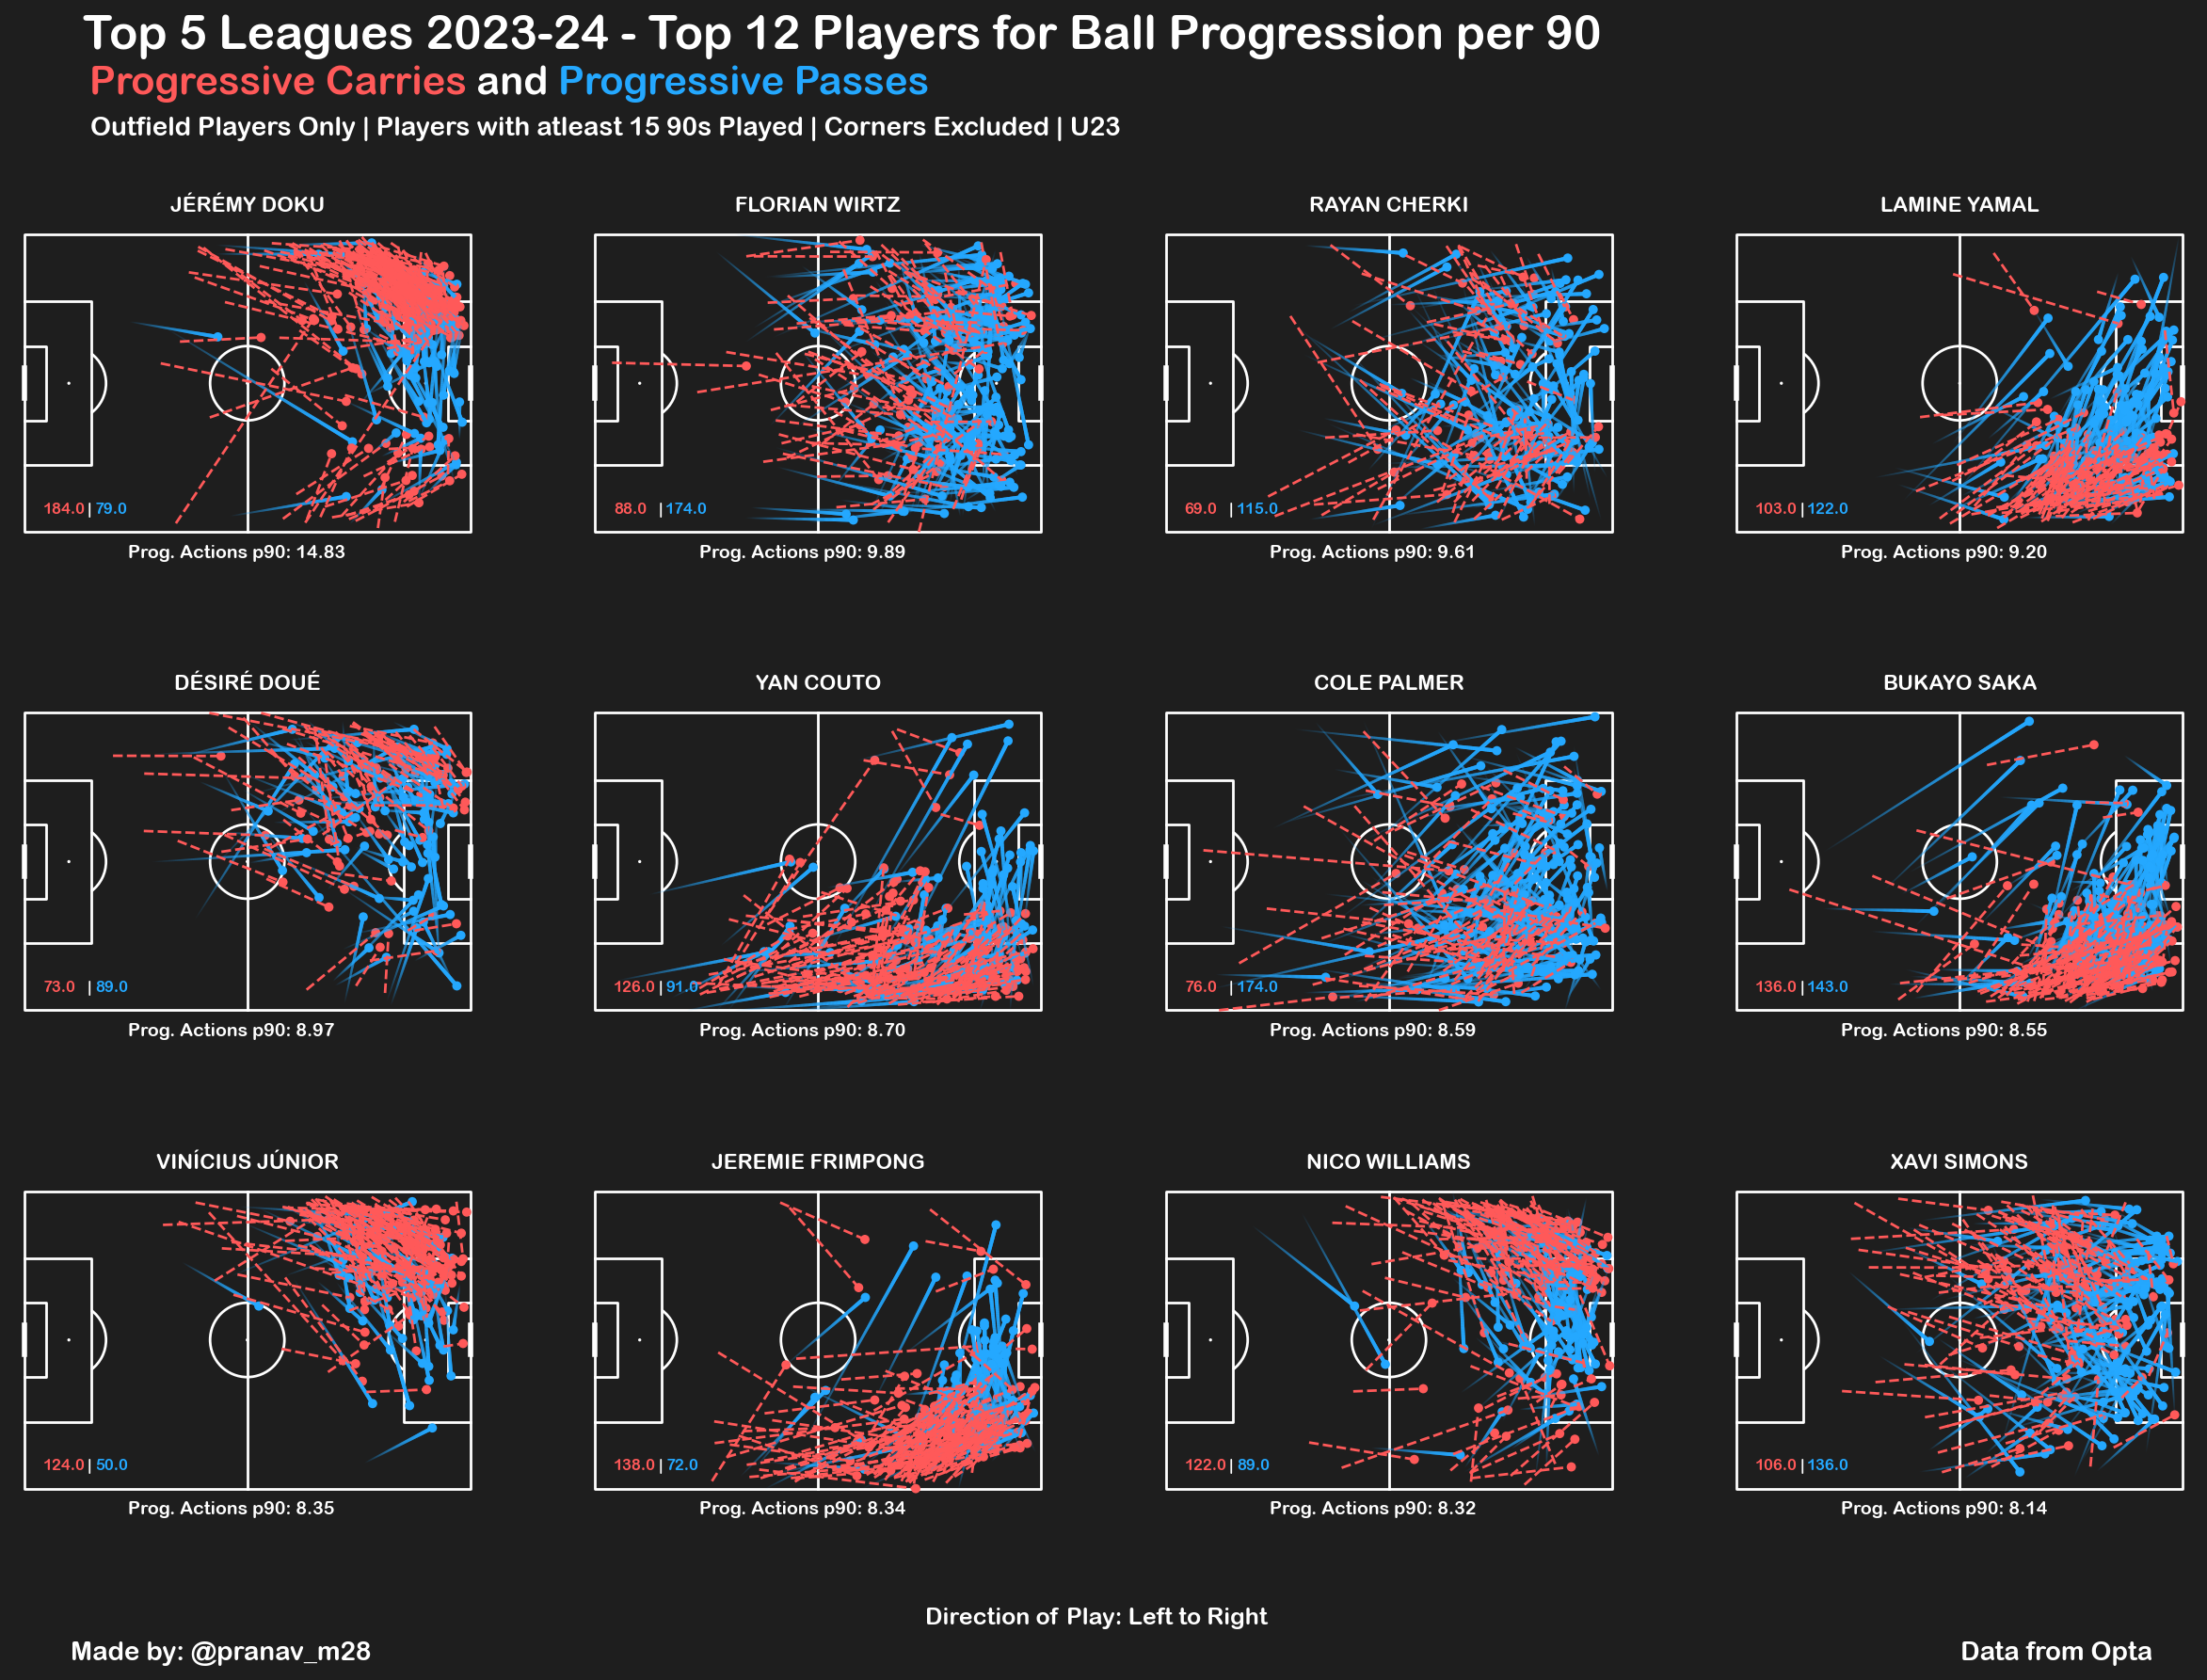

In [253]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
fig.set_facecolor('#1e1e1e')

for ax, (_, player_data) in zip(axs.flatten(), top_12_players.iterrows()):
    player_id = player_data['playerId']
    player_name = player_data['player']
    prog_passes_count = player_data['prog_passes']
    prog_carries_count = player_data['prog_carries']
    prog_act_p90 = player_data['prog_act_p90']
    
    player_passes = prog_passes[prog_passes['playerId'] == player_id]
    player_carries = prog_carries[prog_carries['playerId'] == player_id]
    
   
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#1e1e1e', line_color='#FFFFFF')
    pitch.draw(ax=ax)
    
    # Plot Progressive Passes
    pitch.lines(player_passes.x, player_passes.y, player_passes.endX, player_passes.endY,
                lw=3, transparent=True, comet=True, color='#24a8ff', ax=ax)
    pitch.scatter(player_passes.endX, player_passes.endY, s=50, marker='o', edgecolors='none', c='#24a8ff', ax=ax, alpha=1)
    
    # Plot Progressive Carries
    pitch.lines(player_carries.x, player_carries.y, player_carries.endX, player_carries.endY, 
                ls='dashed', lw=2, transparent=False, comet=False, color='#FF5959', ax=ax)
    pitch.scatter(player_carries.endX, player_carries.endY, s=50, marker='o', edgecolors='none', c='#FF5959', ax=ax, alpha=1)
    
    ax.invert_yaxis()
    ax.set_title(f'{player_name}', font='Arial Rounded MT Bold' ,color='#FFFFFF', fontsize=16)
    
    ax.text(5, 5, f'{prog_carries_count}', color='#FF5959', font='Arial Rounded MT Bold' ,fontsize=12, ha='left')
    ax.text(17, 5, '|', color='#FFFFFF', font='Arial Rounded MT Bold' ,fontsize=12, ha='left')
    ax.text(19, 5, f'{prog_passes_count}', font='Arial Rounded MT Bold' ,color='#24A8FF', fontsize=12, ha='left')
    
    
    
    ax.text(28, -7, f'Prog. Actions p90: {prog_act_p90:.2f}', font='Arial Rounded MT Bold' ,color='#FFFFFF', fontsize=14, ha='left')


fig_text(0.42, 1.00, "Top 5 Leagues 2023-24 - Top 12 Players for Ball Progression per 90", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=36, fontweight='bold')
fig_text(0.302, 0.97, "<Progressive Carries> and <Progressive Passes>", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=30, fontweight='bold', highlight_textprops=[{"color": '#FF5959'} , {"color": '#24A8FF'}])
                                                                           
fig_text(0.336, 0.94, "Outfield Players Only | Players with atleast 15 90s Played | Corners Excluded | U23", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')

fig_text(0.20, 0.04, "Made by: @pranav_m28", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')
fig_text(0.85, 0.04, "Data from Opta", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')


fig_text(
    0.510, 0.060, "Direction of Play: Left to Right", font='Arial Rounded MT Bold' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)


plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.9, bottom=0.1)
#plt.savefig('Top_12_Progressive_Actions_T5.png', dpi=300, bbox_inches='tight')
plt.show()

In [243]:
#list_1 = result_df['team'].unique().tolist()